<h1 align=center> Facial Expression Recognition With Keras</h1>

<h2>Import Libraries</h2>

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.3.1


<h2>Plotting Sample Images</h2>

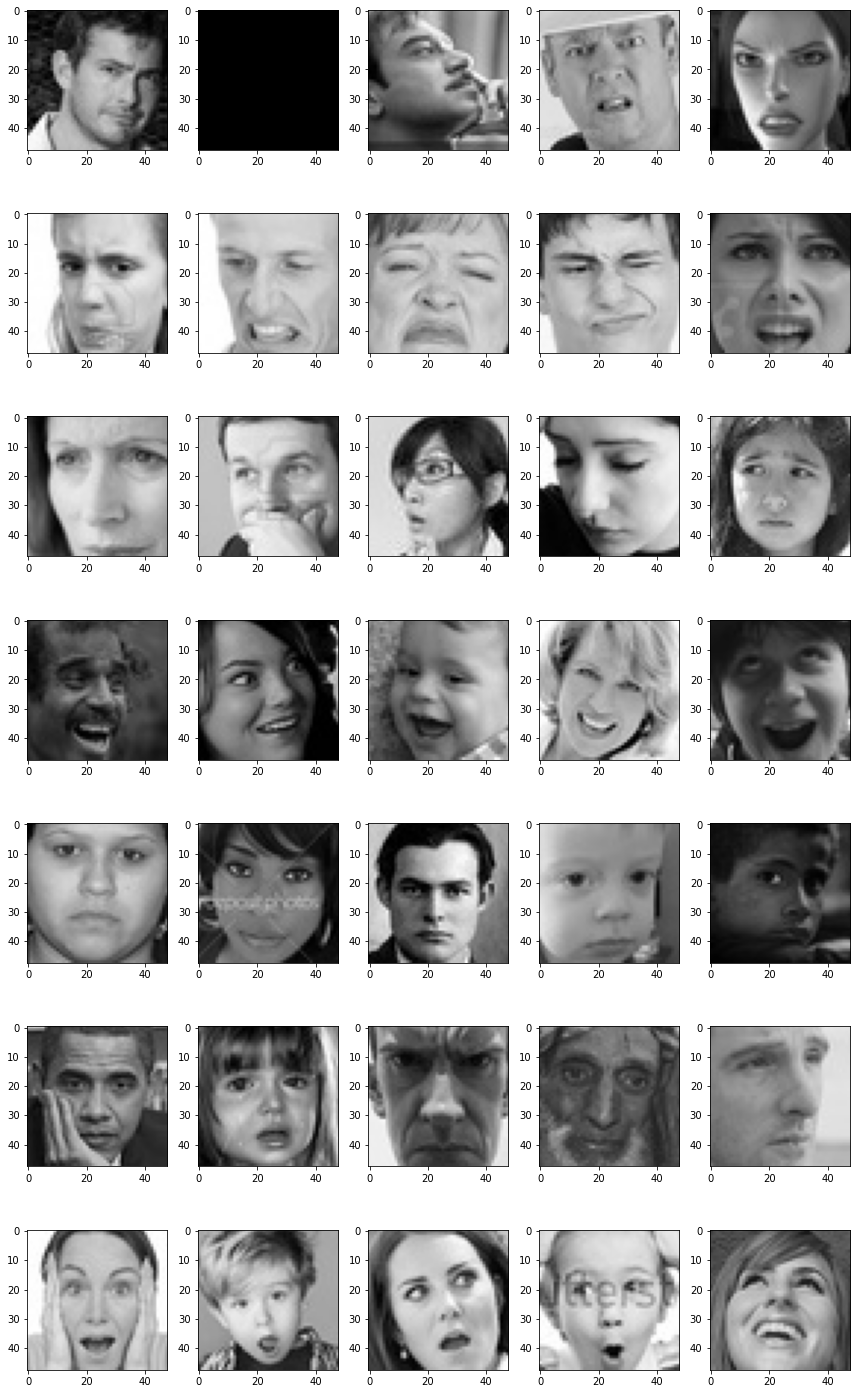

In [ ]:
utils.datasets.fer.plot_example_images(plt).show()

In [ ]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/"+expression))) + " "+expression + " images")

3995 angry images
436 disgust images
4097 fear images
7215 happy images
4965 neutral images
4830 sad images
3171 surprise images


<h2>Generating Training And Validation Batches</h2>

In [ ]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator=datagen_train.flow_from_directory("train/",
                                                 target_size=(img_size, img_size),
                                                 color_mode='grayscale',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)
datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator=datagen_validation.flow_from_directory("test/",
                                                 target_size=(img_size, img_size),
                                                 color_mode='grayscale',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


<h2>Creating CNN Model</h2>

In [ ]:
model = Sequential()
# 1 - conv
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# 2 - conv
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# 3 - conv
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# 4 - conv
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7,activation='softmax'))

opt=Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: &quot;sequential&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 12

<h2>Training and Evaluating Model</h2>

In [ ]:
epochs= 50
steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps=validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                            save_weights_only=True, mode='max', verbose=1)
reduce_lr= ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')
callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

<h2>Representing Model As JSON String</h2>

In [ ]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    